Demo code presentation for teaching the lecture of longitudinal and mixed effects models (CPH684) at the department of epidemiology and biostatistics, University of Arizona. Lectures follow the book [**Applied Longitudinal Analysis, Fitzmaurice, Laird, and Ware**](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470380276.html).  Datasets can be found in their [website](https://www.hsph.harvard.edu/fitzmaur/ala/).

In [8]:
cd("/Users/jzhou/GoogleDriveNoSpace/Teaching/CPH684/JinZhou-Fall16/")
pwd()

"/Users/jzhou/Google Drive/Teaching/CPH684/JinZhou-Fall16"

Machine information:

In [6]:
versioninfo()
Pkg.update()

Julia Version 0.5.0
Commit 3c9d753 (2016-09-19 18:14 UTC)
Platform Info:
  System: Darwin (x86_64-apple-darwin13.4.0)
  CPU: Intel(R) Core(TM) i7-3840QM CPU @ 2.80GHz
  WORD_SIZE: 64
  BLAS: libopenblas (USE64BITINT DYNAMIC_ARCH NO_AFFINITY Sandybridge)
  LAPACK: libopenblas64_
  LIBM: libopenlibm
  LLVM: libLLVM-3.7.1 (ORCJIT, ivybridge)


INFO: Updating METADATA...
INFO: Updating FreqTables master...
INFO: Updating SnpArrays master...
INFO: Updating VarianceComponentModels master...
INFO: Computing changes...
INFO: No packages to install, update or remove


In [26]:
# Load packages
#Pkg.add("DataFrames")
using DataFrames
#Pkg.add("Stats")
using Stats
using PyPlot
plt = PyPlot;

INFO: Recompiling stale cache file /Users/jzhou/.julia/lib/v0.5/ColorTypes.ji for module ColorTypes.
INFO: Recompiling stale cache file /Users/jzhou/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


## Fitting Parametric Curves and Modeling the Covariance

Longitudinal data requires modeling of both mean and covariance structure. Both models are done separately, but are interdependent.
* Covariance between measurements (assuming model for $\Sigma$): 
  - Unstructured
  - Modeled according to specific pattern e.g. autoregressive, banded
  - Random effects (later in the course)
* Mean response over time (assuming model for $\beta$):
  - Analysis of response profile
  - Parametric or semi-parametric curves
  
* Three broad approaches can be distinguished:
   - (1) “unstructured” or arbitrary pattern of covariance 
   - (2) covariance pattern models
   - (3) random effects covariance structure
   
Our objective is to analyze and interpret a two group repeated measures study by considering appropriate covariance structure and parametric curve models: quadratic, linear.
 * Part I: 
     - Data: weight loss study 
     - Choose a covariance structure
 * Part II: 
     - Model the mean using anaylsis of response profiles 
     - Model the mean using parametric curvesInterpret covariate parameter estimates in final model.
     
Data description:

Sixty overweight male subjects were randomly assigned to one of two weight loss programs. Both programs required subjects to follow a strict diet regimen and a daily exercise routine. In addition, subjects in program 1 received daily encouragement from a representative from the study, while subjects in program 2 received no such encouragement. Weight (in pounds) was measured at baseline (month 0) and at 3, 6, and 9 months thereafter.
Key aspects of design: We have a **balanced** study design with all subjects measured at the same four time points. Also, our data are **complete** (no missing data).

In [11]:
cd("/Users/jzhou/Documents/Bin/SASUniversityEdition/myfolders/CPH684/Lec12")

In [148]:
weightloss = readtable("weightloss.dat",separator = ' ',header=false)
#colnames(weightloss)<-c("id", "0","3","6","9", "program")
cnames = ["id", "d0","d3","d6","d9", "program"]
names!(weightloss, [Symbol(cnames[i]) for i in 1:6])
size(weightloss)
weightlossL = stack(weightloss,[:d0,:d3,:d6,:d9],[:id,:program]) 
weightlossL = sort(weightlossL,cols = [:id,:program])

,variable,value,id,program
1,d0,266.1,1,1
2,d3,254.8,1,1
3,d6,222.0,1,1
4,d9,175.5,1,1
5,d0,248.1,2,1
6,d3,198.4,2,1
7,d6,170.8,2,1
8,d9,149.1,2,1
9,d0,253.2,3,1
10,d3,207.1,3,1


Use aggreate function in [DataFrame.jl](https://media.readthedocs.org/pdf/dataframesjl/latest/dataframesjl.pdf) to get summary statistics for ploting.

In [23]:
# Get summary data 
weightlossSummary = aggregate(weightlossL[:,[:value,:variable,:program]], [:variable,:program], [mean,std])

,variable,program,value_mean,value_std
1,d0,1,241.60882352941178,23.01512503533615
2,d0,2,244.95,21.72066757721779
3,d3,1,219.2058823529412,21.197454695351926
4,d3,2,237.00384615384615,20.405832122591438
5,d6,1,193.77058823529413,21.925473346353908
6,d6,2,227.1192307692308,24.62900760048231
7,d9,1,169.0441176470588,21.995966450850748
8,d9,2,218.0346153846154,20.599804704077997


In [25]:
import matplotlib.pyplot as plt
from matplotlib import rc,rcParams
rc('xtick', labelsize=14) 
rc('ytick', labelsize=14)
rc('font',**{'family':'serif','serif':['cmr10']})
# rcParams['mathtext.fontset'] = 'stix'
# rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=True)
%matplotlib inline
from datetime import datetime
import sys
sys.path.append("/Users/andyreagan/work/2015/08-kitchentabletools/")
from dog.toys import *
import numpy as np

The analogue of IPython's `%matplotlib` in Julia is to use the [PyPlot package](https://github.com/stevengj/PyPlot.jl), which gives a Julia interface to Matplotlib including inline plots in IJulia notebooks.   (The equivalent of `numpy` is already loaded by default in Julia.)

Given PyPlot, the analogue of `%matplotlib inline` is `using PyPlot`, since PyPlot defaults to inline plots in IJulia.

To enable separate GUI windows in PyPlot, analogous to `%matplotlib`, do `using PyPlot; pygui(true)`.   To specify a particular gui backend, analogous to `%matplotlib gui`, you can either do `using PyPlot; pygui(:gui); using PyPlot; pygui(true)` (where `gui` is `wx`, `qt`, `tk`, or `gtk`), or you can do `ENV["MPLBACKEND"]=backend; using PyPlot; pygui(true)` (where `backend` is the name of a Matplotlib backend, like `tkagg`).

For more options, see the PyPlot documentation.


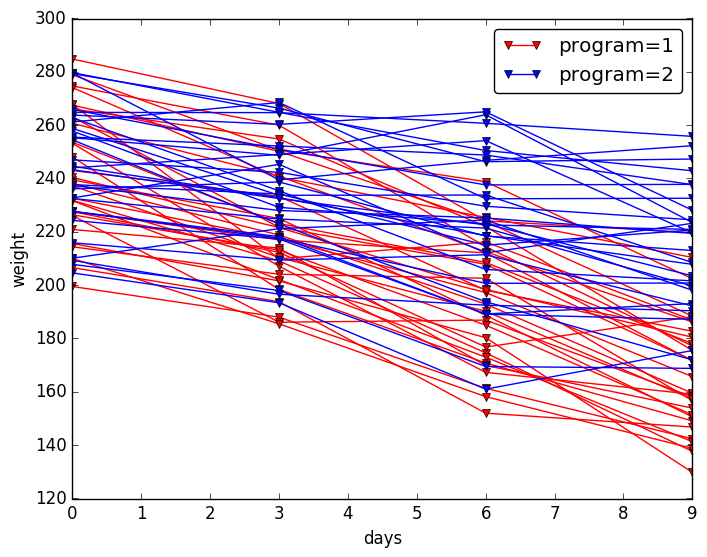

PyObject <matplotlib.legend.Legend object at 0x32bb3ddd8>

In [143]:
Nens = 60
# make the spaghetti plot
x = linspace(0,9,4)
for i in range(1,Nens)
    # println(size(forecastFlux[i,:]))
    # only label the first one
    y = convert(Array,weightloss[i,2:5])
    y = reshape(y,4)
    if i<=30
        if i==1
            plt.plot(x,y, color="red", linewidth=1.0,marker="v",label="program=1")
        else
            plt.plot(x,y, color="red", linewidth=1.0,marker="v")
        end

    else
        if i==31
            plt.plot(x,y, color="blue", linewidth=1.0,marker="v",label="program=2")
        else
            plt.plot(x,y, color="blue", linewidth=1.0,marker="v")
        end
    end
end
xlabel("days")
ylabel("weight")
legend(loc="upper right",fancybox="true")

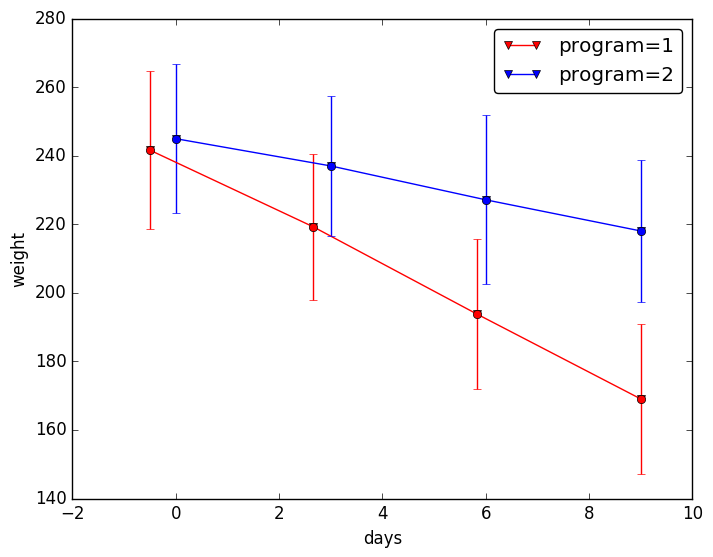

PyObject <matplotlib.legend.Legend object at 0x32d40aba8>

In [147]:
Nens = 60
# make the spaghetti plot
x = linspace(-0.5,9,4)
y = convert(Array,weightlossSummary[weightlossSummary[:program].==1,:value_mean])
plt.plot(x,y, color="red",linewidth=1.0,marker="v",label="program=1")
errs = convert(Array,weightlossSummary[weightlossSummary[:program].==1,:value_std])
errorbar(x, # Original x data points, N values
    y, # Original y data points, N values
    yerr=errs, # Plus/minus error ranges, Nx2 values
    color="red",
    fmt="o")
x = linspace(0,9,4)
y=convert(Array,weightlossSummary[weightlossSummary[:program].==2,:value_mean])
plt.plot(x,y, color="blue", linewidth=1.0,marker="v",label="program=2")
errs = convert(Array,weightlossSummary[weightlossSummary[:program].==2,:value_std])
errorbar(x, # Original x data points, N values
    y, # Original y data points, N values
    yerr=errs, # Plus/minus error ranges, Nx2 values
    color="blue",
    fmt="o")
xlabel("days")
ylabel("weight")
legend(loc="upper right",fancybox="true")
